In [56]:
#!/usr/bin/env python3

import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

batch_size = 30
num_workers = 10

In [57]:
p_latent_space = 100
num_epochs = 10
n_phen = 2

In [58]:


class dataset_pheno(Dataset):
    """a class for importing phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_phens):
        self.datset = pk.load(open(data_file, "rb"))
        self.phens = torch.tensor(np.array(self.datset["phenotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_phens = n_phens

    def __len__(self):
        return len(self.phens)

    def __getitem__(self, idx):
        phenotypes = self.phens[idx][: self.n_phens]
        return phenotypes


In [59]:

#train_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_lowNA_pheno.pk', n_phens=25)
#test_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_highNA_pheno.pk', n_phens=25)

train_data_pheno = dataset_pheno('sim_2trait_dec18_train.pk', n_phens=2)
test_data_pheno = dataset_pheno('sim_2trait_dec18_test.pk', n_phens=2)


In [60]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_loader_pheno = torch.utils.data.DataLoader(
    dataset=train_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_pheno = torch.utils.data.DataLoader(
    dataset=test_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

# how many samples per batch to load


Using device: cuda


/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [61]:

# encoder
class Q_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        super().__init__()
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        batchnorm_momentum = 0.8
        latent_dim = p_latent_space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=phen_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# decoder
class P_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        out_phen_dim = n_phen
        #vabs.n_locs * vabs.n_alleles
        latent_dim = p_latent_space

        batchnorm_momentum = 0.8

        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=out_phen_dim),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


In [62]:
# set minimum variable
EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)


# initialize all networks
Q = Q_net()
P = P_net()

Q.to(device)
P.to(device)

optim_P = torch.optim.Adam(P.parameters(), lr=reg_lr, betas=adam_b)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=reg_lr, betas=adam_b)

In [63]:

# train phen autoencoder
n_phens = n_phen
n_phens_pred = n_phen
rcon_loss = []

start_time = tm.time()

for n in range(num_epochs):
    for i, (phens) in enumerate(train_loader_pheno):
        phens = phens[:, :n_phens]
        #print(phens)
        phens = phens.to(device)  # move data to GPU if it is there
        batch_size = phens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        Q.zero_grad()
        P.zero_grad()

        noise_phens = phens + (0.001**0.5) * torch.randn(phens.shape).to(device)

        z_sample = Q(noise_phens)
        X_sample = P(z_sample)

        # recon_loss = F.mse_loss(X_sample+EPS,phens[:,:n_phens_pred]+EPS)

        recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)

        l1_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 2)

        recon_loss = recon_loss + l1_reg * 0.0000000001 + l2_reg * 0.000000001


        rcon_loss.append(float(recon_loss.detach()))

        recon_loss.backward()
        optim_Q_enc.step()
        optim_P.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 84 r_con_loss: 0.6716815233230591 epoch duration: 0.5299339294433594
Epoch num: 1 batchno 84 r_con_loss: 0.5062183737754822 epoch duration: 0.5232336521148682
Epoch num: 2 batchno 84 r_con_loss: 0.20912736654281616 epoch duration: 0.5095667839050293
Epoch num: 3 batchno 84 r_con_loss: 0.29480916261672974 epoch duration: 0.5104472637176514
Epoch num: 4 batchno 84 r_con_loss: 0.437356173992157 epoch duration: 0.5290772914886475
Epoch num: 5 batchno 84 r_con_loss: 0.3878287076950073 epoch duration: 0.4910097122192383
Epoch num: 6 batchno 84 r_con_loss: 0.3175273537635803 epoch duration: 0.5788588523864746
Epoch num: 7 batchno 84 r_con_loss: 0.48481670022010803 epoch duration: 0.5054736137390137
Epoch num: 8 batchno 84 r_con_loss: 0.2194996029138565 epoch duration: 0.49693751335144043
Epoch num: 9 batchno 84 r_con_loss: 0.4511163532733917 epoch duration: 0.5071671009063721


In [64]:

# test the p-p prediction
Q.eval()

phen_encodings = []
phens = []
phen_latent = []

for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())


In [65]:
phens_df = pd.DataFrame(phens)
#print((phens_df))

phen_encodings_df = pd.DataFrame(phen_encodings)
#print((phen_encodings_df))

[0.9489648938179016, 0.9404959082603455]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.94049591, 0.94134281, 0.94218971, 0.9430366 , 0.9438835 ,
        0.9447304 , 0.9455773 , 0.9464242 , 0.9472711 , 0.948118  ,
        0.94896489]),
 <BarContainer object of 10 artists>)

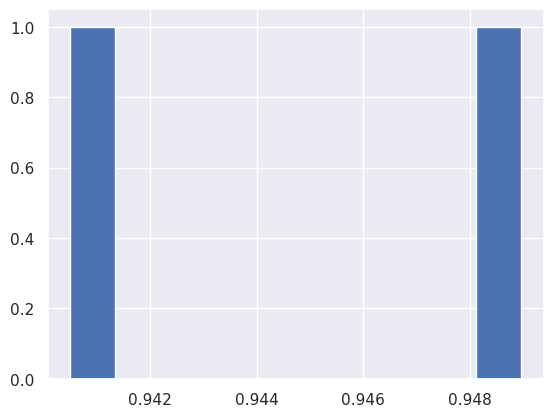

In [66]:
errs = [r2_score(phen_encodings_df[n], phens_df[n]) for n in range(n_phen )]
print(errs)
plt.hist(errs)

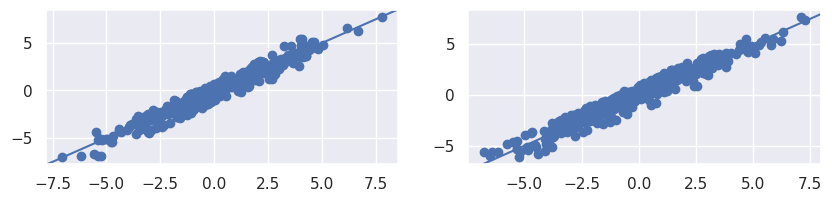

In [67]:
#plt.scatter(phen_encodings_df[1], phens_df[1])


#plot feature ablation importance by predicted feature

plt.figure(figsize=(10, n_phen))

for i in range(n_phen):
    plt.subplot(1, n_phen, i+1)
    plt.scatter(phen_encodings_df[i], phens_df[i])
    plt.axline((0, 0), slope=1)


850
0.4511163532733917


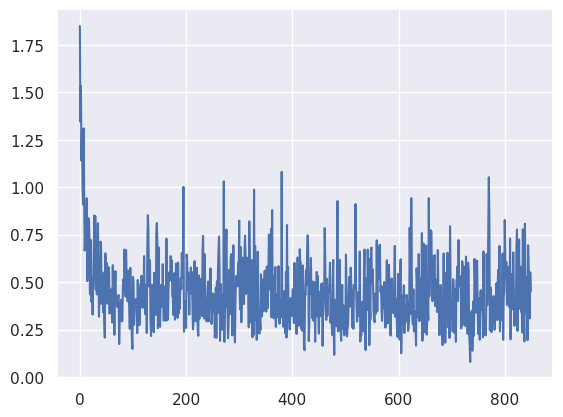

In [68]:
plt.plot(rcon_loss)
print(len(rcon_loss))
print(rcon_loss[-1])

<Axes: >

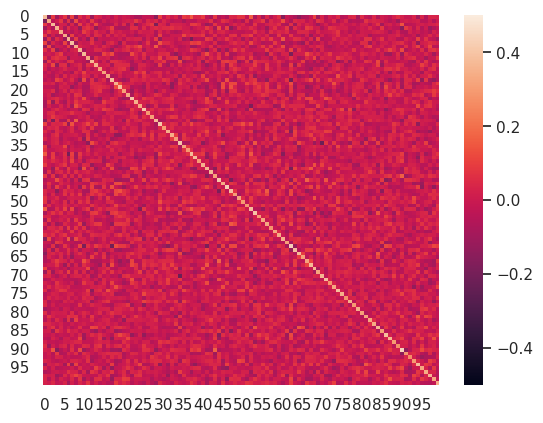

In [69]:

W = P.state_dict()['decoder.0.weight'].cpu()
W_trans = W.T
S = np.log(np.matmul(W_trans, W) + 1)
sns.heatmap(S, vmin=-0.5, vmax=0.5)


In [70]:
#define MSE with no averaging to keep phenotypes loss seperate per phenotype
def sequential_forward_attr_phen_phen(input, phens):
    """puts together two models for use of captum feature importance"""
    mod_2_input = Q(input)
    X_sample = P(mod_2_input)
    output = F.mse_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS, reduction="none")
    return output


fa_p = FeatureAblation(sequential_forward_attr_phen_phen)


In [71]:
fa_attr = []


for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())
    fa_attr.append(list(fa_p.attribute(inputs=(ph, ph),perturbations_per_eval = 1)[0].squeeze().detach().cpu().numpy()))

/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [72]:
###########
#iterate over all batches
#change to take mean of batch
df_batch = []
means = []
dfmean = pd.DataFrame()

for sublist in fa_attr: #iterate over each batch
    df_batch = pd.DataFrame(sublist)
    for i in range(n_phen): #iterate over every one of 5 phenotypes
        means = pd.DataFrame(df_batch.iloc[i::n_phen].mean(axis=0)).T #calculate mean importance by averaging over the 30 observations in the batch
        means['input'] = i #column to keep track of which output feature this data relates to
        dfmean = pd.concat([dfmean, means])


In [73]:
dfmean

,0,1,input
0,-5.339650,-0.813267,0
0,-1.383496,-3.863081,1
0,-5.394655,-0.730835,0
0,-0.134610,-8.443127,1
0,-4.442307,-1.334894,0
0,-0.754311,-5.871424,1
0,-6.826519,-0.368132,0
0,-1.511717,-4.464631,1
0,-4.900456,-1.128964,0
0,-1.033078,-4.653630,1


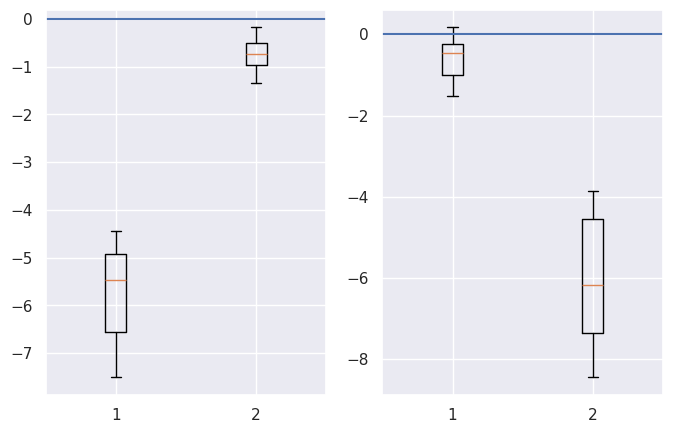

In [74]:
#plot feature ablation importance by predicted feature

plt.figure(figsize=(21, 5))

for i in range(n_phen):
    plt.subplot(1, 5, i+1)
    dfplot = dfmean.loc[dfmean['input'] == i]
    dfplot = dfplot.iloc[:, :-1]
    plt.boxplot(dfplot)
    plt.axhline(y = 0)